In [1]:
def mount_drive(dir):
  import os
  colab = 1
  if colab == 1:
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    current_folder = dir
    dest_folder = '/content/drive/My Drive/' + current_folder
    os.chdir(dest_folder)
    print('\n Current path: ' + os.getcwd())

mount_drive('')

Mounted at /content/drive

 Current path: /content/drive/My Drive


In [2]:
pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 4.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from keras.layers import Conv2D, MaxPooling1D, Activation, Flatten, Dense, AveragePooling1D, LSTM, GRU, Lambda
from keras.layers import MaxPooling2D, AveragePooling2D, BatchNormalization, Dropout, Input, Conv1D, Reshape
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from nba_api.stats.static import players
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import leagueleaders
from sklearn.preprocessing import LabelEncoder
import re
from nba_api.stats.endpoints import playergamelog
import requests
from nba_api.stats.static import teams

In [4]:
def normalizer(data_train, data_test, normalization_bit=1):
  if normalization_bit == 1:
    scaler = MinMaxScaler()
  elif normalization_bit == 2:
    scaler = StandardScaler()
  elif normalization_bit == 3:
    scaler = MaxAbsScaler()
  elif normalization_bit == 4:
    scaler = RobustScaler()
  else:
    return data_train, data_test


  data_train = scaler.fit_transform(data_train)
  data_test = scaler.transform(data_test)

  return data_train, data_test

In [5]:
def getMetrics(y_pred, y_true):
  mse = mean_squared_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  print("MSE: ", mse)
  print("R2: ", r2)

In [6]:
def compile_fit(model, X_train, y_train, X_test, y_test):

  model.compile(
      optimizer = 'adam',
      loss = 'mse',
      metrics = ['mse']
  )

  history = model.fit(
      X_train,
      y_train,
      validation_split = 0.2,
      epochs = 100,
      batch_size = 64,
      #callbacks = [early_stop],
      validation_data = [X_test, y_test],
      verbose = 1
      )

  y_pred = model.predict(X_test)

  return history, y_pred

In [7]:
def dnn_regression(input_shape, X_train, X_test, y_train, y_test):
  model = Sequential([
      Dense(64, activation = 'relu', input_shape = (input_shape,)),
      Dropout(0.3),
      Dense(32, activation = 'relu'),
      Dropout(0.3),
      Dense(16, activation = 'relu'),
      Dropout(0.3),
      Dense(1)
  ])

  history, y_pred = compile_fit(model, X_train, y_train, X_test, y_test)

  return history, y_pred, model

In [8]:
def cnn_regression(input_shape, X_train, y_train, X_test, y_test, kernel_size = 1, pool_size = 2):

  model = Sequential([
      Conv1D(32, kernel_size = kernel_size, activation = 'relu', input_shape = input_shape),
      MaxPooling1D(pool_size = pool_size),
      Conv1D(64, kernel_size = kernel_size, activation = 'relu'),
      Flatten(),
      Dense(64, activation = 'relu'),
      Dropout(0.3),
      Dense(32, activation = 'relu'),
      Dense(1)
    ])

  history, y_pred = compile_fit(model, X_train, y_train, X_test, y_test)

  return history, y_pred, model

In [9]:
def lstm_regression(input_shape, X_train, y_train, X_test, y_test):
  model = Sequential([
      LSTM(64, activation = 'tanh', input_shape = input_shape, return_sequences = True),
      Dropout(0.3),
      LSTM(32, activation = 'tanh'),
      Dense(32, activation = 'relu'),
      Dropout(0.3),
      Dense(16, activation = 'relu'),
      Dense(1)
  ])

  history, y_pred = compile_fit(model, X_train, y_train, X_test, y_test)

  return history, y_pred, model

In [10]:
def gru_regression(input_shape, X_train, y_train, X_test, y_test):
  model = Sequential([
      GRU(64, activation = 'tanh', input_shape = input_shape, return_sequences = True),
      Dropout(0.3),
      GRU(32, activation = 'tanh'),
      Dense(32, activation = 'relu'),
      Dropout(0.3),
      Dense(16, activation = 'relu'),
      Dense(1)
  ])

  history, y_pred = compile_fit(model, X_train, y_train, X_test, y_test)

  return history, y_pred, model

In [11]:
def extra_tree_regression(X_train, y_train, X_test, y_test, n_trees = 100):
  model = ExtraTreesRegressor(
            n_estimators = n_trees,
            random_state = 0
          )
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  return y_pred, model

In [12]:
def plotLosses(history):
  plt.figure(figsize = (8,6))
  plt.plot(history.history['loss'], 'r', label = 'Training_loss / MSE')
  plt.plot(history.history['val_loss'], 'b', label = 'Test_loss / MSE')
  plt.title("Train-Test MSE / Loss")
  plt.legend()
  plt.show()

In [13]:
original_get = requests.get

def custom_get(*args, **kwargs):
    kwargs['timeout'] = 60
    return original_get(*args, **kwargs)

requests.get = custom_get

In [14]:
def clac_avg_PER(league_avg_stats):
    points = league_avg_stats['PTS'].mean()
    fga = league_avg_stats['FGA'].mean()
    fta = league_avg_stats['FTA'].mean()
    tov = league_avg_stats['TOV'].mean()
    reb = league_avg_stats['REB'].mean()
    ast = league_avg_stats['AST'].mean()
    blk = league_avg_stats['BLK'].mean()
    stl = league_avg_stats['STL'].mean()
    pf = league_avg_stats['PF'].mean()

    missed_fg = (fga - league_avg_stats['FGM'].mean())
    missed_ft = (fta - league_avg_stats['FTM'].mean())

    player_efficiency_avg = (
        points + reb + ast + stl + blk - missed_fg - missed_ft - tov - pf
    )

    return player_efficiency_avg


In [15]:
def calc_PER(player_stats, league_avg_stats):
    player_efficiency_avg = clac_avg_PER(league_avg_stats)

    points = player_stats['PTS']
    fga = player_stats['FGA']
    fta = player_stats['FTA']
    tov = player_stats['TOV']
    reb = player_stats['REB']
    ast = player_stats['AST']
    blk = player_stats['BLK']
    stl = player_stats['STL']
    pf = player_stats['PF']
    min_played = player_stats['MIN']

    missed_fg = (fga - player_stats['FGM'])
    missed_ft = (fta - player_stats['FTM'])

    player_efficiency = (
        points + reb + ast + stl + blk - missed_fg - missed_ft - tov - pf
    )

    return player_efficiency/(player_efficiency_avg * min_played)

In [16]:
def calculate_ts_pct(player_stats):

    pts = player_stats['PTS']
    fga = player_stats['FGA']
    fta = player_stats['FTA']

    ts_pct = pts / (2 * (fga + 0.44 * fta))
    return ts_pct

In [17]:
def calculate_ast_to_ratio(player_stats):
    ast = player_stats['AST']
    tov = player_stats['TOV']

    return ast / tov

In [18]:
def extra_player_metrics(df_player, df_leaders):
    df_player["PER_score"] = calc_PER(df_player ,df_leaders)
    df_player["PCT_score"] = calculate_ts_pct(df_player)
    df_player["AST_ratio"]= calculate_ast_to_ratio(df_player)

    return df_player

In [19]:
def home_away_averages(player_df):
    player_df["Home_Average_PTS"] = player_df[player_df['Home'] == 1]['PTS'].mean()
    player_df["Away_Average_PTS"] = player_df[player_df['Home'] == 0]['PTS'].mean()

    player_df["Home_Average_REB"] = player_df[player_df['Home'] == 1]['REB'].mean()
    player_df["Away_Average_REB"] = player_df[player_df['Home'] == 0]['REB'].mean()

    player_df["Home_Average_AST"] = player_df[player_df['Home'] == 1]['AST'].mean()
    player_df["Away_Average_AST"] = player_df[player_df['Home'] == 0]['AST'].mean()

    return player_df

In [20]:
def recent_game_averages(player_df):
    player_df = player_df.copy()

    # Reverse the DataFrame to calculate the averages starting from the most recent game
    player_df = player_df[::-1]

    # Points of last # of games
    player_df.loc[:, "Avg_points_last_3"] = player_df["PTS"].rolling(window=3).mean()
    player_df.loc[:, "Avg_points_last_5"] = player_df["PTS"].rolling(window=5).mean()
    player_df.loc[:, "Avg_points_last_7"] = player_df["PTS"].rolling(window=7).mean()

    # Assists of last # of games
    player_df.loc[:, "Avg_Assists_last_3"] = player_df["AST"].rolling(window=3).mean()
    player_df.loc[:, "Avg_Assists_last_5"] = player_df["AST"].rolling(window=5).mean()
    player_df.loc[:, "Avg_Assists_last_7"] = player_df["AST"].rolling(window=7).mean()

    # Rebounds of last # of games
    player_df.loc[:, "Avg_Rebounds_last_3"] = player_df["REB"].rolling(window=3).mean()
    player_df.loc[:, "Avg_Rebounds_last_5"] = player_df["REB"].rolling(window=5).mean()
    player_df.loc[:, "Avg_Rebounds_last_7"] = player_df["REB"].rolling(window=7).mean()

    # Reverse back to original order
    player_df = player_df[::-1]

    return player_df

In [21]:
def calc_possesions(team_df, column_name):
    team_df[column_name] = (
    team_df['FGA'] +
    0.44 * team_df['FTA'] -
    team_df['OREB'] +
    team_df['TOV'])

    return team_df

In [22]:
def win_loss_ecoder(df):
    labelEncoder = LabelEncoder()
    df['WL'] = labelEncoder.fit_transform(df['WL'])

    return df

In [23]:
def get_player(player_name):

    #get specific player data
    player_dict = players.get_players()
    player_stat = [player for player in player_dict if player['full_name'] == player_name][0]
    players_id_stat = player_stat['id']

    #Get current year
    gamelog_player_df = playergamelog.PlayerGameLog(player_id = players_id_stat, season = "2024").get_data_frames()[0]
    gamelog_player_df = pd.DataFrame(gamelog_player_df)

    #get average leaguge data
    leaders = leagueleaders.LeagueLeaders(season='2023-24')
    df_leaders = leaders.get_data_frames()[0]
    df_leaders = pd.DataFrame(df_leaders)

    gamelog_player_df = extra_player_metrics(gamelog_player_df, df_leaders)

    #Encode Wins and loss to binary
    gamelog_player_df = win_loss_ecoder(gamelog_player_df)

    #Regex for home an away binary encoding
    gamelog_player_df["Home"] = gamelog_player_df["MATCHUP"].apply(lambda x: 0 if re.search(r'@', x) else 1)

    gamelog_player_df = home_away_averages(gamelog_player_df)
    gamelog_player_df = recent_game_averages(gamelog_player_df)

    gamelog_player_df["GAME_ID"] = gamelog_player_df["Game_ID"]

    #Drop cols
    gamelog_player_df = gamelog_player_df.drop(columns=["Player_ID", "MATCHUP", "SEASON_ID", "VIDEO_AVAILABLE", "Game_ID"])

    return gamelog_player_df

In [24]:
def combine_games(df):

    agg_functions = {
        'GAME_ID': 'first',
        'GAME_DATE': 'first',
        'WL': lambda x: x.loc[x.idxmax()],
        'MIN': 'sum',
        'PTS': 'sum',
        'FGM': 'sum',
        'FGA': 'sum',
        'FG_PCT': lambda x: x.sum() / len(x),
        'FG3M': 'sum',
        'FG3A': 'sum',
        'FG3_PCT': lambda x: x.sum() / len(x),
        'FTM': 'sum',
        'FTA': 'sum',
        'FT_PCT': lambda x: x.sum() / len(x),
        'OREB': 'sum',
        'DREB': 'sum',
        'REB': 'sum',
        'AST': 'sum',
        'STL': 'sum',
        'BLK': 'sum',
        'TOV': 'sum',
        'PF': 'sum',
        'PLUS_MINUS': 'sum',
        'Home': lambda x: x.loc[x.idxmax()],
        'OPP': 'first',
        'SEASON_ID': 'first',
        'TEAM_ID': 'first',
        'TEAM_ABBREVIATION': 'first',
        'TEAM_NAME': 'first',
        'MATCHUP': 'first'
        }

    df = df.groupby(df['GAME_ID']).aggregate(agg_functions)

    return df


In [25]:
def get_team(team_name):
    #Get starting team data
    team_dict = teams.get_teams()
    team_stat = [team for team in team_dict if team['full_name'] == team_name][0]
    team_stat_ID = team_stat['id']
    team_stat_games = leaguegamefinder.LeagueGameFinder(team_id_nullable = team_stat_ID).get_data_frames()[0]

    #Filter only the most recent season
    team_stat_games['GAME_DATE'] = pd.to_datetime(team_stat_games['GAME_DATE'], errors='coerce')
    comparison_date = pd.to_datetime("2024-8-21")
    team_stat_games = team_stat_games[team_stat_games["GAME_DATE"] > comparison_date]

    #Encode Wins and loss to binary
    team_stat_games = win_loss_ecoder(team_stat_games)

    #Regex for home an away binary encoding
    team_stat_games["Home"] = team_stat_games["MATCHUP"].apply(lambda x: 0 if re.search(r'@', x) else 1)

    #Regex what team is being played then encode to numeric values
    team_stat_games["OPP"] = team_stat_games["MATCHUP"].str.extract(r'[.@]\s*(\w+)')
    #labelEncoder = LabelEncoder()
    #team_stat_games["OPP"] = labelEncoder.fit_transform(team_stat_games["OPP"])

    team_stat_games = combine_games(team_stat_games)
    team_stat_games = calc_possesions(team_stat_games, "Team_possesions")

    #Drop cols
    team_stat_games = team_stat_games.drop(columns=["SEASON_ID", "TEAM_ID", "TEAM_ABBREVIATION", "TEAM_NAME", "MATCHUP"])

    return team_stat_games


In [26]:
def calc_usage_pace_offensive_rating(df):
    required_columns = ['FGA', 'FTA', 'TOV', 'MIN_team', 'PTS_team', 'Team_possesions_team', 'OREB']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], format='%b %d, %Y')
    df = df.sort_values(by="GAME_DATE", ascending=True)

    # Calculate per-game stats
    df['Player_possessions'] = (
        df['FGA'] - df['OREB'] + df['TOV'] + (0.44 * df['FTA'])
    )

    df['Offensive_Rating'] = (
        (df['PTS'] / df['Player_possessions']) * 100
    ).fillna(0)

    # Handle cases where possessions might be zero or very small
    df['Player_possessions'] = df['Player_possessions'].replace(0, 0.1)
    df['Offensive_Rating'] = df['Offensive_Rating'].replace([float('inf'), -float('inf')], 0)

    # Calculate cumulative averages
    df['Cumulative_Offensive_Rating'] = df['Offensive_Rating'].expanding().mean()

    df['team_possessions'] = (
        df['FGA_team'] - df['OREB_team'] + df['TOV_team'] + (0.44 * df['FTA_team'])
    )

    df['team_off_rating'] = (
        (df['PTS_team']/df['Team_possesions_team']) * 100
    ).fillna(0)

    df['team_possessions'] = df['Team_possesions_team'].replace(0, 0.1)
    df['team_off_rating'] = df['team_off_rating'].replace([float('inf'), -float('inf')], 0)

    # Calculate cumulative averages
    df['Cumulative_team_off_Rating'] = df['team_off_rating'].expanding().mean()

    df['Team_Pace'] = (
        (df['team_possessions'] / (df['MIN_team'] / 5)) * 48
    ).replace([float('inf'), -float('inf')], 0).fillna(0)

    df['Cumulative_Team_Pace'] = df['Team_Pace'].expanding().mean()

    # Calculate Usage Percentage
    df['Cumulative_FGA'] = df['FGA'].cumsum()
    df['Cumulative_FTA'] = df['FTA'].cumsum()
    df['Cumulative_TO'] = df['TOV'].cumsum()
    df['Cumulative_MIN'] = df['MIN_team'].cumsum()
    df['Cumulative_PTS'] = df['PTS_team'].cumsum()

    df['Usage_Percentage'] = (
        100
        * (
            (df['Cumulative_FGA'] + 0.44 * df['Cumulative_FTA'] + df['Cumulative_TO'])
            * df['MIN_team']
        )
        / (df['Cumulative_MIN'] * df['team_possessions'])
    )

    # Drop cumulative columns if not needed for output
    df = df.drop(columns=['Cumulative_FGA', 'Cumulative_FTA', 'Cumulative_TO', 'Cumulative_MIN', 'Cumulative_PTS'])

    return df

In [27]:
from functools import lru_cache

def calculate_defensive_rating_up_to_game(main_team_data):
    # Get all NBA team data upfront
    all_teams = teams.get_teams()
    team_id_map = {team['full_name']: team['id'] for team in all_teams}

    # Cache to store previously fetched opponent data
    opp_team_cache = {}

    all_team_def_ratings = []

    for index, row in main_team_data.iterrows():
        opp_name = row['full_opp_name']
        game_date = pd.to_datetime(row['GAME_DATE'], errors='coerce')

        # Get opponent's data from cache or API
        if opp_name not in opp_team_cache:
            opp_team_ID = team_id_map.get(opp_name)
            if opp_team_ID:
                opp_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=opp_team_ID).get_data_frames()[0]
                opp_team_cache[opp_name] = opp_games
            else:
                opp_team_cache[opp_name] = pd.DataFrame()  # Handle missing teams

        opp_team_games = opp_team_cache[opp_name]

        if not opp_team_games.empty:
            opp_team_games['GAME_DATE'] = pd.to_datetime(opp_team_games['GAME_DATE'], errors='coerce')
            opp_team_games = opp_team_games[opp_team_games['GAME_DATE'] < game_date]

            opp_team_games = calc_possesions(opp_team_games, "opp_possessions")
            opp_team_games['CUMULATIVE_POINTS_ALLOWED'] = opp_team_games['PTS'].cumsum()
            opp_team_games['CUMULATIVE_OPP_POSSESSIONS'] = opp_team_games['opp_possessions'].cumsum()

            if not opp_team_games.empty:
                def_rating = (
                    100 * opp_team_games['CUMULATIVE_POINTS_ALLOWED'].iloc[-1] /
                    opp_team_games['CUMULATIVE_OPP_POSSESSIONS'].iloc[-1]
                )
            else:
                def_rating = None
        else:
            def_rating = None

        all_team_def_ratings.append({
            'GAME_ID': row['GAME_ID'],
            'GAME_DATE_player': row['GAME_DATE'],
            'Opp_Team': opp_name,
            'Defensive_Rating': def_rating
        })

    return pd.DataFrame(all_team_def_ratings)

In [28]:
"""def calculate_defensive_rating_up_to_game(main_team_data):
    all_team_def_ratings = []

    #iterate though all the data and obtain the opposing teams data
    for index, row in main_team_data.iterrows():
        opp_name = row['full_opp_name']
        game_date = pd.to_datetime(row['GAME_DATE'], errors='coerce')

        team_dict = teams.get_teams()
        opp_team = [team for team in team_dict if team['full_name'] == opp_name][0]
        opp_team_ID = opp_team['id']
        opp_team_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=opp_team_ID).get_data_frames()[0]

        opp_team_games['GAME_DATE'] = pd.to_datetime(opp_team_games['GAME_DATE'], errors='coerce')
        opp_team_games = opp_team_games[opp_team_games['GAME_DATE'] < game_date]

        opp_team_games = calc_possesions(opp_team_games, "opp_possessions")
        opp_team_games['CUMULATIVE_POINTS_ALLOWED'] = opp_team_games['PTS'].cumsum()
        opp_team_games['CUMULATIVE_OPP_POSSESSIONS'] = opp_team_games['opp_possessions'].cumsum()

        #calulate defensive rating doe each team
        if not opp_team_games.empty:
            def_rating = (
                100 * opp_team_games['CUMULATIVE_POINTS_ALLOWED'].iloc[-1] /
                opp_team_games['CUMULATIVE_OPP_POSSESSIONS'].iloc[-1]
            )
        else:
            def_rating = None

        #only keep what is needed for adding to main data frame
        all_team_def_ratings.append({
            'GAME_ID': row['GAME_ID'],
            'GAME_DATE_player': row['GAME_DATE'],
            'Opp_Team': opp_name,
            'Defensive_Rating': def_rating
        })

    return pd.DataFrame(all_team_def_ratings)"""

'def calculate_defensive_rating_up_to_game(main_team_data):\n    all_team_def_ratings = []\n\n    #iterate though all the data and obtain the opposing teams data\n    for index, row in main_team_data.iterrows():\n        opp_name = row[\'full_opp_name\']\n        game_date = pd.to_datetime(row[\'GAME_DATE\'], errors=\'coerce\')\n\n        team_dict = teams.get_teams()\n        opp_team = [team for team in team_dict if team[\'full_name\'] == opp_name][0]\n        opp_team_ID = opp_team[\'id\']\n        opp_team_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=opp_team_ID).get_data_frames()[0]\n\n        opp_team_games[\'GAME_DATE\'] = pd.to_datetime(opp_team_games[\'GAME_DATE\'], errors=\'coerce\')\n        opp_team_games = opp_team_games[opp_team_games[\'GAME_DATE\'] < game_date]\n\n        opp_team_games = calc_possesions(opp_team_games, "opp_possessions")\n        opp_team_games[\'CUMULATIVE_POINTS_ALLOWED\'] = opp_team_games[\'PTS\'].cumsum()\n        opp_team_games[\'CUMU

In [30]:
""""def calculate_opponent_pace_up_to_game(main_team_data):
    all_team_paces = []

    #iterate through the main data obtaining oposing teams data
    for index, row in main_team_data.iterrows():
        opp_name = row['full_opp_name']
        game_date = pd.to_datetime(row['GAME_DATE_player'], errors='coerce')

        team_dict = teams.get_teams()
        opp_team_list = [team for team in team_dict if team['full_name'].strip().lower() == opp_name.strip().lower()]
        opp_team = opp_team_list[0]
        opp_team_ID = opp_team['id']
        opp_team_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=opp_team_ID).get_data_frames()[0]

        opp_team_games['GAME_DATE'] = pd.to_datetime(opp_team_games['GAME_DATE'], errors='coerce')
        opp_team_games = opp_team_games[opp_team_games['GAME_DATE'] < game_date]

        opp_team_games = calc_possesions(opp_team_games, "opp_possessions")

        opp_team_games['GAME_MINUTES'] = 48

        opp_team_games['CUMULATIVE_OPP_POSSESSIONS'] = opp_team_games['opp_possessions'].cumsum()
        opp_team_games['CUMULATIVE_GAME_MINUTES'] = opp_team_games['GAME_MINUTES'].cumsum()

        #calculate the pace of the opposing team
        if not opp_team_games.empty:
            avg_pace = (
                opp_team_games['CUMULATIVE_OPP_POSSESSIONS'].iloc[-1] *
                48 /
                opp_team_games['CUMULATIVE_GAME_MINUTES'].iloc[-1]
            )
        else:
            avg_pace = None

        #only keep what is needed for megring the data
        all_team_paces.append({
            'GAME_ID': row['GAME_ID'],
            'GAME_DATE_player': row['GAME_DATE_player'],
            'Opp_Team': opp_name,
            'Opponent_Pace': avg_pace
        })

    return pd.DataFrame(all_team_paces)
"""

'"def calculate_opponent_pace_up_to_game(main_team_data):\n    all_team_paces = []\n\n    #iterate through the main data obtaining oposing teams data\n    for index, row in main_team_data.iterrows():\n        opp_name = row[\'full_opp_name\']\n        game_date = pd.to_datetime(row[\'GAME_DATE_player\'], errors=\'coerce\')\n\n        team_dict = teams.get_teams()\n        opp_team_list = [team for team in team_dict if team[\'full_name\'].strip().lower() == opp_name.strip().lower()]\n        opp_team = opp_team_list[0]\n        opp_team_ID = opp_team[\'id\']\n        opp_team_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=opp_team_ID).get_data_frames()[0]\n\n        opp_team_games[\'GAME_DATE\'] = pd.to_datetime(opp_team_games[\'GAME_DATE\'], errors=\'coerce\')\n        opp_team_games = opp_team_games[opp_team_games[\'GAME_DATE\'] < game_date]\n\n        opp_team_games = calc_possesions(opp_team_games, "opp_possessions")\n\n        opp_team_games[\'GAME_MINUTES\'] = 48\n\n  

In [31]:
def calculate_opponent_pace_up_to_game(main_team_data):
    # Get all NBA team data upfront
    all_teams = teams.get_teams()
    team_id_map = {team['full_name'].strip().lower(): team['id'] for team in all_teams}

    # Cache to store previously fetched opponent data
    opp_team_cache = {}

    all_team_paces = []

    for index, row in main_team_data.iterrows():
        opp_name = row['full_opp_name'].strip().lower()
        game_date = pd.to_datetime(row['GAME_DATE_player'], errors='coerce')

        # Get opponent's data from cache or API
        if opp_name not in opp_team_cache:
            opp_team_ID = team_id_map.get(opp_name)
            if opp_team_ID:
                try:
                    opp_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=opp_team_ID).get_data_frames()[0]
                    opp_team_cache[opp_name] = opp_games
                except Exception as e:
                    print(f"Error fetching data for {opp_name}: {e}")
                    opp_team_cache[opp_name] = pd.DataFrame()  # Handle errors gracefully
            else:
                opp_team_cache[opp_name] = pd.DataFrame()  # Handle missing teams

        opp_team_games = opp_team_cache[opp_name]

        if not opp_team_games.empty:
            opp_team_games['GAME_DATE'] = pd.to_datetime(opp_team_games['GAME_DATE'], errors='coerce')
            opp_team_games = opp_team_games[opp_team_games['GAME_DATE'] < game_date]

            opp_team_games = calc_possesions(opp_team_games, "opp_possessions")

            opp_team_games['GAME_MINUTES'] = 48  # Assume each game is 48 minutes
            opp_team_games['CUMULATIVE_OPP_POSSESSIONS'] = opp_team_games['opp_possessions'].cumsum()
            opp_team_games['CUMULATIVE_GAME_MINUTES'] = opp_team_games['GAME_MINUTES'].cumsum()

            if not opp_team_games.empty:
                avg_pace = (
                    opp_team_games['CUMULATIVE_OPP_POSSESSIONS'].iloc[-1] *
                    48 /
                    opp_team_games['CUMULATIVE_GAME_MINUTES'].iloc[-1]
                )
            else:
                avg_pace = None
        else:
            avg_pace = None

        all_team_paces.append({
            'GAME_ID': row['GAME_ID'],
            'GAME_DATE_player': row['GAME_DATE_player'],
            'Opp_Team': row['full_opp_name'],
            'Opponent_Pace': avg_pace
        })

    return pd.DataFrame(all_team_paces)

In [32]:
nba_teams = {
    "ATL": "Atlanta Hawks",
    "BOS": "Boston Celtics",
    "BKN": "Brooklyn Nets",
    "CHA": "Charlotte Hornets",
    "CHI": "Chicago Bulls",
    "CLE": "Cleveland Cavaliers",
    "DAL": "Dallas Mavericks",
    "DEN": "Denver Nuggets",
    "DET": "Detroit Pistons",
    "GSW": "Golden State Warriors",
    "HOU": "Houston Rockets",
    "IND": "Indiana Pacers",
    "LAC": "Los Angeles Clippers",
    "LAL": "Los Angeles Lakers",
    "MEM": "Memphis Grizzlies",
    "MIA": "Miami Heat",
    "MIL": "Milwaukee Bucks",
    "MIN": "Minnesota Timberwolves",
    "NOP": "New Orleans Pelicans",
    "NYK": "New York Knicks",
    "OKC": "Oklahoma City Thunder",
    "ORL": "Orlando Magic",
    "PHI": "Philadelphia 76ers",
    "PHX": "Phoenix Suns",
    "POR": "Portland Trail Blazers",
    "SAC": "Sacramento Kings",
    "SAS": "San Antonio Spurs",
    "TOR": "Toronto Raptors",
    "UTA": "Utah Jazz",
    "WAS": "Washington Wizards"
}

In [78]:
in_player = input("What player do you want to bet on? ")
players_team = input("What team does your player play for? ")
opp_team = input("What team is your player playing? ")
bet_type = input("ast, reb, pts? ")

What player do you want to bet on? Jalen Brunson
What team does your player play for? New York Knicks
What team is your player playing? Brooklyn Nets
ast, reb, pts? pts


In [79]:
response = requests.get("https://stats.nba.com/some_endpoint", timeout=60)

In [80]:
player_df = get_player(in_player)

In [81]:
players_team_df = get_team(players_team)

In [82]:
opp_team_df = get_team(opp_team)

In [83]:
players_team_df = players_team_df.rename(columns=lambda col: f"{col}_team")
players_full_stat = pd.merge(player_df, players_team_df, left_on='GAME_ID', right_index=True, how='inner')

In [84]:
players_full_stat = calc_usage_pace_offensive_rating(players_full_stat)

opp_team_df['full_opp_name'] = [
            nba_teams[team] if team in nba_teams else "Unknown Team"
            for team in opp_team_df["OPP"]
]

In [86]:
opp_team_df_def = calculate_defensive_rating_up_to_game(opp_team_df)

<ipython-input-21-d46f37d6d746>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df[column_name] = (
<ipython-input-27-ce9dd57ca5d5>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opp_team_games['CUMULATIVE_POINTS_ALLOWED'] = opp_team_games['PTS'].cumsum()
<ipython-input-27-ce9dd57ca5d5>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [87]:
opp_team_df = opp_team_df.reset_index(drop=True)
opp_team_df_def = opp_team_df_def.reset_index(drop=True)

opp_team_df = pd.merge(opp_team_df, opp_team_df_def, on='GAME_ID', how='inner')

In [88]:
opp_team_df_pace = calculate_opponent_pace_up_to_game(opp_team_df)
opp_team_df = pd.merge(opp_team_df, opp_team_df_pace, on='GAME_ID', how='inner')

<ipython-input-21-d46f37d6d746>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df[column_name] = (
<ipython-input-31-ffd4d629cc20>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opp_team_games['GAME_MINUTES'] = 48  # Assume each game is 48 minutes
<ipython-input-31-ffd4d629cc20>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Error fetching data for new orleans pelicans: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)


<ipython-input-21-d46f37d6d746>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df[column_name] = (
<ipython-input-31-ffd4d629cc20>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opp_team_games['GAME_MINUTES'] = 48  # Assume each game is 48 minutes
<ipython-input-31-ffd4d629cc20>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [89]:
df = pd.read_csv("player_data_df.csv")
df.head()

,GAME_ID,GAME_DATE_player_x,WL_player,MIN_player,FGM_player,FGA_player,FG_PCT_player,FG3M_player,FG3A_player,FG3_PCT_player,...,Offensive_Rating,Cumulative_Offensive_Rating,team_possessions,team_off_rating,Cumulative_team_off_Rating,Team_Pace,Cumulative_Team_Pace,Usage_Percentage,player_name,team_name
0,22400064,2024-10-23,1,37,4,9,0.444,0,3,0.000,...,62.785388,62.785388,104.24,115.118956,115.118956,103.807469,103.807469,17.766692,Jalen Johnson,Atlanta Hawks
1,22400079,2024-10-25,1,41,4,15,0.267,1,4,0.250,...,84.388186,73.586787,103.72,120.516776,117.817866,103.720000,103.763734,18.992442,Jalen Johnson,Atlanta Hawks
2,22400100,2024-10-27,0,29,3,13,0.231,1,3,0.333,...,43.750000,63.641191,105.76,98.335855,111.323862,105.760000,104.429156,17.776621,Jalen Johnson,Atlanta Hawks
3,22400103,2024-10-28,0,39,11,17,0.647,1,3,0.333,...,137.571157,82.123683,106.84,111.381505,111.338273,106.840000,105.031867,18.597251,Jalen Johnson,Atlanta Hawks
4,22400121,2024-10-30,0,40,9,21,0.429,1,5,0.200,...,103.960396,86.491025,107.24,111.898545,111.450327,107.240000,105.473494,19.707561,Jalen Johnson,Atlanta Hawks


In [90]:
opp_team_df["Defensive_Rating"] = opp_team_df["Defensive_Rating"].mean()
opp_team_df["Opponent_Pace"] = opp_team_df["Opponent_Pace"].mean()
opp_team_df = opp_team_df.iloc[[-1]]


In [91]:
players_full_stat = players_full_stat.iloc[[-1]]

In [92]:
print(opp_team_df)
print(players_full_stat)

       GAME_ID  GAME_DATE  WL  MIN  PTS  FGM  FGA  FG_PCT  FG3M  FG3A  ...  \
46  0022401224 2024-12-16   0  241  101   34   81    0.42    14    34  ...   

    Home  OPP  Team_possesions        full_opp_name  GAME_DATE_player_x  \
46     1  CLE           102.56  Cleveland Cavaliers          2024-12-16   

             Opp_Team_x  Defensive_Rating  GAME_DATE_player_y  \
46  Cleveland Cavaliers        104.855918          2024-12-16   

             Opp_Team_y  Opponent_Pace  
46  Cleveland Cavaliers      97.072965  

[1 rows x 33 columns]
   GAME_DATE  WL  MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  FTM  ...  \
0 2025-01-20   1   39   12   18   0.667     3     5      0.6    7  ...   

   Team_possesions_team  Player_possessions  Offensive_Rating  \
0                102.24               25.84        131.578947   

   Cumulative_Offensive_Rating  team_possessions  team_off_rating  \
0                   111.256715            102.24       116.392801   

   Cumulative_team_off_Rating  Team_P

In [93]:
opp_team_df = opp_team_df.reset_index(drop=True)
important_player = players_full_stat.reset_index(drop=True)

test_player = pd.concat([opp_team_df, players_full_stat], axis=1)
test_player = pd.DataFrame(test_player)

In [94]:
print(df.columns.tolist())

['GAME_ID', 'GAME_DATE_player_x', 'WL_player', 'MIN_player', 'FGM_player', 'FGA_player', 'FG_PCT_player', 'FG3M_player', 'FG3A_player', 'FG3_PCT_player', 'FTM_player', 'FTA_player', 'FT_PCT_player', 'OREB_player', 'DREB_player', 'REB_player', 'AST_player', 'STL_player', 'BLK_player', 'TOV_player', 'PF_player', 'PTS_player', 'PLUS_MINUS_player', 'PER_score', 'PCT_score', 'AST_ratio', 'Home_player', 'OPP_player', 'OPP_encoded', 'Home_Average_PTS', 'Away_Average_PTS', 'Home_Average_REB', 'Away_Average_REB', 'Home_Average_AST', 'Away_Average_AST', 'Avg_points_last_3', 'Avg_points_last_5', 'Avg_points_last_7', 'Avg_Assists_last_3', 'Avg_Assists_last_5', 'Avg_Assists_last_7', 'Avg_Rebounds_last_3', 'Avg_Rebounds_last_5', 'Avg_Rebounds_last_7', 'GAME_ID_player', 'GAME_ID_team', 'GAME_DATE_team', 'WL_team', 'MIN_team', 'PTS_team', 'FGM_team', 'FGA_team', 'FG_PCT_team', 'FG3M_team', 'FG3A_team', 'FG3_PCT_team', 'FTM_team', 'FTA_team', 'FT_PCT_team', 'OREB_team', 'DREB_team', 'REB_team', 'AST_te

In [95]:
#bet_type = "pts"

if bet_type.lower() == "pts":
  features = [
    'Avg_points_last_3', 'Avg_points_last_5', 'Avg_points_last_7', 'Usage_Percentage',
    'Home_Average_PTS', 'Away_Average_PTS', 'PCT_score', 'Defensive_Rating', 'Opponent_Pace', 'Cumulative_Offensive_Rating',
    'Cumulative_team_off_Rating']
elif bet_type.lower() == "reb":
  features = [
    'Avg_Rebounds_last_3', 'Avg_Rebounds_last_5', 'Avg_Rebounds_last_7', 'Usage_Percentage',
    'Home_Average_REB', 'Away_Average_REB', 'PCT_score', 'Defensive_Rating', 'Opponent_Pace', 'Cumulative_Offensive_Rating',
    'Cumulative_team_off_Rating']
elif bet_type.lower() == "ast":
  features = [
    'Avg_Assists_last_3', 'Avg_Assists_last_5', 'Avg_Assists_last_7', 'Usage_Percentage',
    'Home_Average_AST', 'Away_Average_AST', 'PCT_score', 'Defensive_Rating', 'Opponent_Pace', 'Cumulative_Offensive_Rating',
    'Cumulative_team_off_Rating']
else:
  print("invalid input!!!")

In [96]:
# PTS_player

X = df[features]
if bet_type.lower() == "pts":
  y = df['PTS_player']
elif bet_type.lower() == "reb":
  y = df['REB_player']
elif bet_type.lower() == "ast":
  y = df['AST_player']

#y = df['PTS_player'] # make sure to change this (elif statment)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=19)

In [97]:
X_train, X_test = normalizer(X_train, X_test, 7)

In [98]:
test_player = test_player[features]

In [99]:
test_player

,Avg_points_last_3,Avg_points_last_5,Avg_points_last_7,Usage_Percentage,Home_Average_PTS,Away_Average_PTS,PCT_score,Defensive_Rating,Opponent_Pace,Cumulative_Offensive_Rating,Cumulative_team_off_Rating
0,32.666667,34.6,30.428571,23.306296,23.714286,28.5,0.744308,104.855918,97.072965,111.256715,118.597039


# Random Forest

In [54]:
model_RM = RandomForestRegressor(n_estimators=100, random_state=23)
model_RM.fit(X_train, y_train)

y_pred_RM = model_RM.predict(X_test)

getMetrics(y_pred_RM, y_test)

MSE:  11.583464047510278
R2:  0.8483056315205395


In [55]:
importance = pd.DataFrame({"Feature": X.columns, "Importance": model_RM.feature_importances_})
importance.sort_values(by="Importance", ascending=False, inplace=True)
print(importance)

                        Feature  Importance
0             Avg_points_last_3    0.621668
6                     PCT_score    0.214807
3              Usage_Percentage    0.053535
9   Cumulative_Offensive_Rating    0.017484
1             Avg_points_last_5    0.014519
8                 Opponent_Pace    0.014391
2             Avg_points_last_7    0.013704
7              Defensive_Rating    0.013354
10   Cumulative_team_off_Rating    0.013331
5              Away_Average_PTS    0.011811
4              Home_Average_PTS    0.011397


In [100]:
y_pred_test_RM = model_RM.predict(test_player)
print(y_pred_test_RM[0])

37.44


# Linear Regression

In [57]:
df_LM = df
df_LM = df_LM.dropna()

X_LM = df_LM[features]
#y_LM = df_LM['PTS_player'] #make sure to change this(need an elif statment)
if bet_type.lower() == "pts":
  y_LM = df_LM['PTS_player']
elif bet_type.lower() == "reb":
  y_LM = df_LM['REB_player']
elif bet_type.lower() == "ast":
  y_LM = df_LM['AST_player']


X_train_LM, X_test_LM, y_train_LM, y_test_LM = train_test_split(X_LM, y_LM, test_size=.2, random_state=19)

X_train_LM, X_test_LM = normalizer(X_train_LM, X_test_LM, 7)

model_LM = LinearRegression()
model_LM.fit(X_train_LM, y_train_LM)

y_pred_LM = model_LM.predict(X_test_LM)
getMetrics(y_pred_LM, y_test_LM)

MSE:  18.797371287520715
R2:  0.7595785587422872


In [101]:
y_pred_test_LM = model_LM.predict(test_player)
print(y_pred_test_LM[0])

32.11198146877551


# XGB

In [59]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

model_xgb = xgb.train(
    params={
        'objective': 'reg:squarederror',
        'learning_rate': 0.1,
        'max_depth': 6,
        'colsample_bytree': 0.8,
    },
    dtrain=dtrain,
    num_boost_round=100
)

y_pred_xgb = model_xgb.predict(dtest)

getMetrics(y_pred_xgb, y_test)

MSE:  11.176664352416992
R2:  0.8536329865455627


In [102]:
dtest_single = xgb.DMatrix(test_player)

y_pred_test_XGB = model_xgb.predict(dtest_single)
print(y_pred_test_XGB[0])

40.751656


# DNN

In [105]:
y_mean = y_train_LM.mean()
y_std = y_train_LM.std()

y_train_scaled = (y_train_LM - y_mean) / y_std
y_test_scaled = (y_test_LM - y_mean) / y_std

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(X_train_LM)
x_test_scaled = scaler.fit_transform(X_test_LM)
test_val_X_scaled = scaler.transform(test_player)  # Use transform, not fit_transform


In [62]:
dnn_hist, dnn_y_pred, dnn_model = dnn_regression(X_train.shape[1], x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7802 - mse: 0.7802 - val_loss: 0.3282 - val_mse: 0.3282
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4591 - mse: 0.4591 - val_loss: 0.2927 - val_mse: 0.2927
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3984 - mse: 0.3984 - val_loss: 0.2948 - val_mse: 0.2948
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3647 - mse: 0.3647 - val_loss: 0.2777 - val_mse: 0.2777
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3365 - mse: 0.3365 - val_loss: 0.2694 - val_mse: 0.2694
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3342 - mse: 0.3342 - val_loss: 0.2813 - val_mse: 0.2813
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3127 - mse: 0.3127 - val_loss: 0.2635 - val_mse: 0.2635
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3028 - mse: 0.3028 - val_loss: 0.2809 - val_mse: 0.2809
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3229 - mse: 0.3

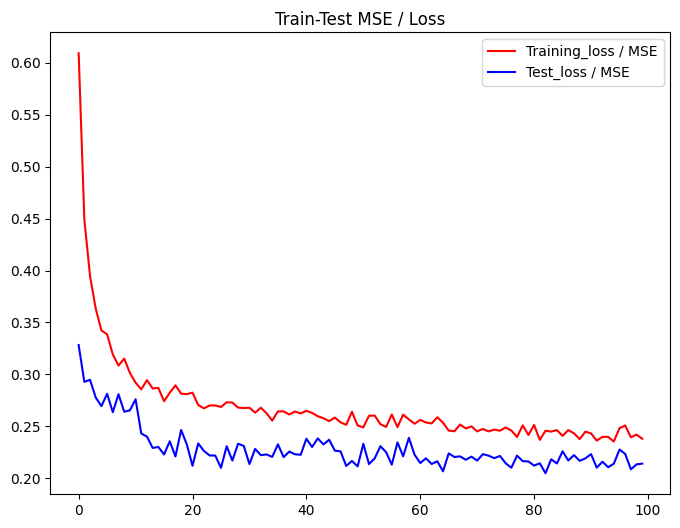

In [63]:
plotLosses(dnn_hist)

In [106]:
getMetrics(dnn_y_pred, y_test_scaled)
y_pred_test_dnn = dnn_model.predict(test_val_X_scaled)
y_pred_test_original = (y_pred_test_dnn * y_std) + y_mean

print(y_pred_test_original)

MSE:  0.21400645432822582
R2:  0.7893043229176481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[32.261753]]


# CNN

In [65]:
X_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1).astype('float32')
X_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1).astype('float32')

input_cnn = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

In [66]:
history_cnn, y_pred_cnn, cnn_model = cnn_regression(input_cnn, X_train_reshaped, y_train_scaled, X_test_reshaped, y_test_scaled)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4830 - mse: 0.4830 - val_loss: 0.3023 - val_mse: 0.3023
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3174 - mse: 0.3174 - val_loss: 0.3050 - val_mse: 0.3050
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3177 - mse: 0.3177 - val_loss: 0.2822 - val_mse: 0.2822
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2844 - mse: 0.2844 - val_loss: 0.2730 - val_mse: 0.2730
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2820 - mse: 0.2820 - val_loss: 0.2932 - val_mse: 0.2932
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2840 - mse: 0.2840 - val_loss: 0.2705 - val_mse: 0.2705
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2734 - mse: 0.2734 - val_loss: 0.2679 - val_mse: 0.2679
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2871 - mse: 0.2871 - val_loss: 0.2748 - val_mse: 0.2748
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2637 - mse: 0.2

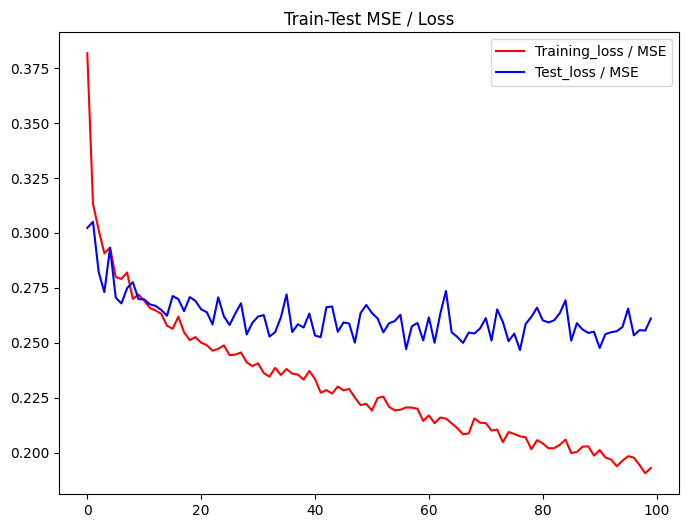

In [67]:
plotLosses(history_cnn)

In [107]:
test_val_X_scaled_cnn = test_val_X_scaled.reshape(test_val_X_scaled.shape[0], test_val_X_scaled.shape[1], 1).astype('float32')

getMetrics(y_pred_cnn, y_test_scaled)
y_pred_test_cnn = cnn_model.predict(test_val_X_scaled_cnn)
y_pred_test_original_cnn = (y_pred_test_cnn[0] * y_std) + y_mean

print(y_pred_test_original_cnn)

MSE:  0.2610550886019343
R2:  0.7429835524286642
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[29.20503]


In [69]:
history_lstm, y_pred_lstm, lstm_model = lstm_regression(input_cnn, X_train_reshaped, y_train_scaled, X_test_reshaped, y_test_scaled)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.6158 - mse: 0.6158 - val_loss: 0.3619 - val_mse: 0.3619
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3767 - mse: 0.3767 - val_loss: 0.3716 - val_mse: 0.3716
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3694 - mse: 0.3694 - val_loss: 0.3800 - val_mse: 0.3800
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3521 - mse: 0.3521 - val_loss: 0.3534 - val_mse: 0.3534
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.3728 - mse: 0.3728 - val_loss: 0.3581 - val_mse: 0.3581
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3551 - mse: 0.3551 - val_loss: 0.3440 - val_mse: 0.3440
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3649 - mse: 0.3649 - val_loss: 0.3662 - val_mse: 0.3662
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3517 - mse: 0.3517 - val_loss: 0.3447 - val_mse: 0.3447
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3611 -

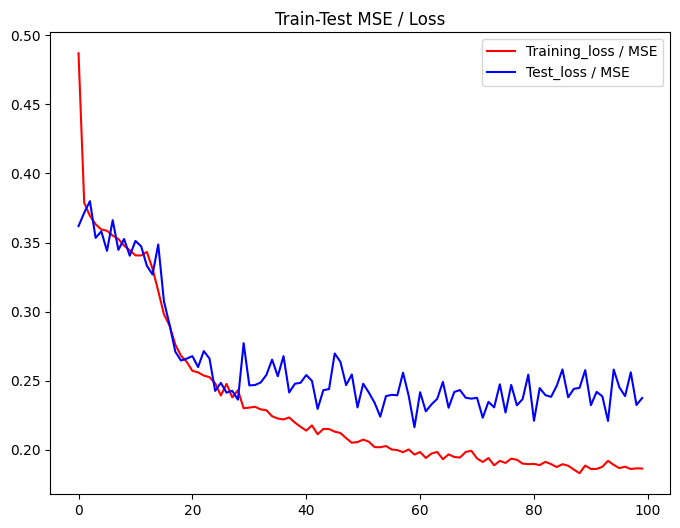

In [70]:
plotLosses(history_lstm)

In [108]:
test_val_X_scaled_lstm = test_val_X_scaled_cnn

getMetrics(y_pred_lstm, y_test_scaled)
y_pred_test_lstm = lstm_model.predict(test_val_X_scaled_lstm)
y_pred_test_original_lstm = (y_pred_test_lstm[0] * y_std) + y_mean

print(y_pred_test_original_lstm)

MSE:  0.23742741479412793
R2:  0.7662456953693696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[32.931427]


# GRU

In [72]:
history_gru, y_pred_gru, gru_model = gru_regression(input_cnn, X_train_reshaped, y_train_scaled, X_test_reshaped, y_test_scaled)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.6769 - mse: 0.6769 - val_loss: 0.3726 - val_mse: 0.3726
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.3781 - mse: 0.3781 - val_loss: 0.3791 - val_mse: 0.3791
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.3724 - mse: 0.3724 - val_loss: 0.3743 - val_mse: 0.3743
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.3671 - mse: 0.3671 - val_loss: 0.3526 - val_mse: 0.3526
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3508 - mse: 0.3508 - val_loss: 0.3676 - val_mse: 0.3676
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3491 - mse: 0.3491 - val_loss: 0.3428 - val_mse: 0.3428
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.3581 - mse: 0.3581 - val_loss: 0.3443 - val_mse: 0.3443
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3553 - mse: 0.3553 - val_loss: 0.3677 - val_mse: 0.3677
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.3515 

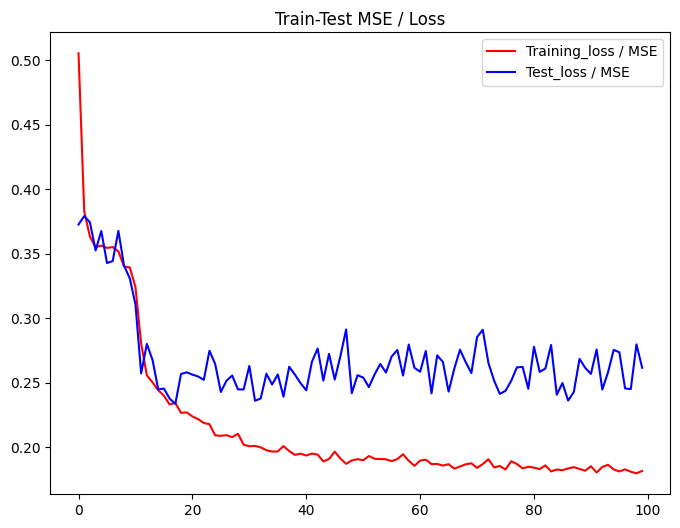

In [73]:
plotLosses(history_gru)

In [109]:
test_val_X_scaled_gru = test_val_X_scaled_cnn

getMetrics(y_pred_gru, y_test_scaled)
y_pred_test_gru = gru_model.predict(test_val_X_scaled_gru)
y_pred_test_original_gru = (y_pred_test_gru[0] * y_std) + y_mean

print(y_pred_test_original_gru)


MSE:  0.2616684621462484
R2:  0.7423796680522359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[34.687325]


# Extra tree

In [75]:
y_pred_extra, model_extra = extra_tree_regression(x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled)

In [110]:
getMetrics(y_pred_extra, y_test_scaled)
y_pred_test_extra = model_extra.predict(test_val_X_scaled)
y_pred_test_original_extra = (y_pred_test_extra[0] * y_std) + y_mean

print(y_pred_test_original_extra)

MSE:  0.2101616516844356
R2:  0.7930896447147139
37.219999999999985


# Average

In [111]:
(y_pred_test_RM[0] + y_pred_test_LM[0] + y_pred_test_XGB[0] + y_pred_test_original + y_pred_test_original_cnn + y_pred_test_original_lstm + y_pred_test_original_gru + y_pred_test_original_extra)/8

array([[34.576145]], dtype=float32)